<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/german_to_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 24th Nov, 2021
# Myfolder: /home/ashok/Documents/germanToenglish
#
# References:
# https://medium.com/analytics-vidhya/a-must-read-nlp-tutorial-on-neural-machine-translation-the-technique-powering-google-translate-c5c8d97d7587
# https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b

# Use of Sparse Categorical Cross-entropy:
#     https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/?t=156531526256#rating-57  

## Data Sources:
# Tab-delimited Bilingual Sentence Pairs 
#  Hindi--English:   http://www.manythings.org/anki/

# VM: lubuntu_deeplearning_II.vdi

# Model for speech translation

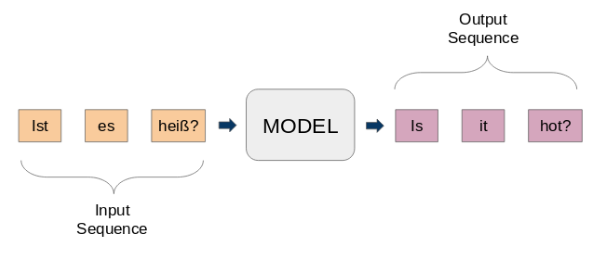

## 1.0 Import Required Libraries

In [ ]:
## Call libraries
# 1.0 For data manipulation
import numpy as np
import pandas as pd

# 1.1 For text cleaning
import string
import re

# 1.2 For NN model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.layers import TimeDistributed,Bidirectional,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# 1.3 For text processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.4 For loading model
from tensorflow.keras.models import load_model

# 1.5 Misc & for plotting model
import os, time
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline 
from skimage import io


In [ ]:
#@title
# 1.6

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


**Data Source:** Download the text file that contains English sentences and coresponding German sentence separated by tab (ie pairs of sentences; one pair per line) from [here](http://www.manythings.org/anki/deu-eng.zip). And extract this file "deu.txt" in your working directory. For future use, place this file in your gdrive.

## 2.0 Define functions to read text data

Our data is a text file of English-German sentence pairs. We will read the file using the function defined below and then do a little processing.

In [ ]:
# 2.0 Define function to read raw text file
#     Full file is returned as just ONE string:

def read_text(filename):
    # 2.0.1 Open the file, read only ('r') and text ('t') modes
    file = open(filename, mode='rt', encoding='utf-8')
    # 2.0.2 Read all text as one string
    #       newlines are substituted by \n 
    #       and tabs by \t
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs. Each pair is a list. So we have a list of lists. <br> Each pair is separated by '\n'. So we first split on '\n'. And then split each pair into English sentences and German sentences by splitting on '\t'.

In [ ]:
# 2.1. 
#    i) Split the file of ONE string into
#       multiple strings broken at newline.
#       We get list of many strings:

#    ii) Then, split each string on tab to get 
#        both parts of split in a list.
#
#    Example input string = 'Hi.\tHallo!\nHi.\tGrüß Gott!\nRun!\tLauf!\n'

def to_lines(text):
    # 2.1.0 Ist remove leading and trailing spaces strip()
    #       then split it at newline
    #       'Hi.\tHallo!\nHi.\tGrüß Gott!\nRun!\tLauf!\n' transforms to
    #       ['Hi.\tHallo!', 'Hi.\tGrüß Gott!','Run!\tLauf!']
    sentences = text.strip().split('\n')

    # 2.1.1 Next split over tab to create two words. 
    #       This splitting creates an inner list
    #       [['Hi.', 'Hallo!'], ['Hi.','Grüß Gott!]',['Run!','Lauf!']]
    sentences = [i.split('\t') for i in sentences]
    
    return sentences 

## 3.0 Mount gdrive

In [ ]:
# 3.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# 3.1 Path to data folder:

pathToFolder = "/gdrive/MyDrive/Colab_data_files/germantoenglish"

## 4.0 Read Data<br>
1. Read data and look at the sentences<br>
2. Select 50000 initial pairs<br>
3. Also split data into `train` and `test`

In [ ]:
# 4.0 Where is our file 'deu.txt'
os.chdir(pathToFolder)

# 4.1 Read it as a string
#     It contains, line by line:
#     english    german  pairs

data = read_text("deu.txt")

In [ ]:
# 4.2 Check:

print(type(data))        # Data is one very long string
print(len(data))         # 12724556 characters
print(data[:50])         # First 50 characters

<class 'str'>
12724556
Hi.	Hallo!
Hi.	Grüß Gott!
Run!	Lauf!
Wow!	Potzdonn


In [ ]:
# 4.3. Transform read file to a list of lists.
#       Each inner list has [english  german] pair:

deu_eng = to_lines(data)

In [ ]:
# 4.4 Check:

print(type(deu_eng))     # List
print(len(deu_eng))      # Elements in the list: 176692

<class 'list'>
176692


In [ ]:
# 4.5 Print lists:

print(deu_eng[:5])       # List of 5 elements or pairs
print(deu_eng[400:410])  # List of lists

[['Hi.', 'Hallo!'], ['Hi.', 'Grüß Gott!'], ['Run!', 'Lauf!'], ['Wow!', 'Potzdonner!'], ['Wow!', 'Donnerwetter!']]
[['Tom lied.', 'Tom log.'], ['Tom lies.', 'Tom lügt.'], ['Tom lost.', 'Tom hat verloren.'], ['Tom paid.', 'Tom hat gezahlt.'], ['Tom quit.', 'Tom hat aufgehört.'], ['Tom swam.', 'Tom schwamm.'], ['Tom swam.', 'Tom ist geschwommen.'], ['Tom wept.', 'Tom weinte.'], ["Tom's up.", 'Tom ist auf.'], ['Too late.', 'Zu spät.']]


In [ ]:
# 4.6 Convert list of lists to a numpy array 
#      We now have an array with feature 
#      [0] for english and feature [1] for german

deu_eng = np.array(deu_eng)
print(deu_eng.shape)     # (176692, 2)
print(deu_eng[500,:])

(176692, 2)
['Go for it.' 'Tue es.']


In [ ]:
# 4.6.1
# Just have a look:

deu_eng[410:415]
print("\n---")
print(deu_eng[410:415, 0])     # List of english sentences
print("\n---")
print(deu_eng[410:415, 1])     # Corresponding list of german sentences

array([['Trust me.', 'Vertraue mir.'],
       ['Trust me.', 'Vertraut mir!'],
       ['Trust me.', 'Vertrauen Sie mir!'],
       ['Try hard.', 'Versuch es richtig!'],
       ['Use this.', 'Nimm das hier!']], dtype='<U380')


---
['Trust me.' 'Trust me.' 'Trust me.' 'Try hard.' 'Use this.']

---
['Vertraue mir.' 'Vertraut mir!' 'Vertrauen Sie mir!'
 'Versuch es richtig!' 'Nimm das hier!']


The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [ ]:
# 4.7

deu_eng = deu_eng[:50000,:]     # Our RAM and time is limited. Take less pairs
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Mary has very long hair.', 'Maria hat sehr langes Haar.'],
       ["Mary is Tom's secretary.", 'Maria ist Toms Sekretärin.'],
       ['Mary is a married woman.', 'Maria ist eine verheiratete Frau.']],
      dtype='<U380')

### Split data

In [ ]:
# 4.8 Split our data into train/test:
 
from sklearn.model_selection import train_test_split
train, test = train_test_split(
                                deu_eng,
                                test_size=0.2,
                                random_state = 12
                               )

In [ ]:
# 4.9
train.shape         # (40000,2)
test.shape          # (10000,2)

(40000, 2)

(10000, 2)

## 5.0 Text Pre-Processing
Remove punctuation and convert to lowercase

### Text Cleaning through functions

Remove punctuation and transform to lower case

##### Remove punctuation

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
# 5.1 Remove punctuation
# Ref: https://www.geeksforgeeks.org/python-maketrans-translate-functions/
"""
    Syntax : maketrans(str1, str2, str3)

    Parameters :
    str1 : Specifies the list of characters that need to be replaced.
    str2 : Specifies the list of characters with which the characters need to be replaced.
    str3 : Specifies the list of characters that needs to be deleted.

    Returns : Returns the translation table which specifies the conversions that can be used by translate()
              It returns a dictionary mapping Unicode integers to Unicode ordinals, strings or None.

"""


'\n    Syntax : maketrans(str1, str2, str3)\n\n    Parameters :\n    str1 : Specifies the list of characters that need to be replaced.\n    str2 : Specifies the list of characters with which the characters need to be replaced.\n    str3 : Specifies the list of characters that needs to be deleted.\n\n    Returns : Returns the translation table which specifies the conversions that can be used by translate()\n              It returns a dictionary mapping Unicode integers to Unicode ordinals, strings or None.\n\n'

In [ ]:
# 5.2
s = "this is a good book!"
str.maketrans('ig', 'wj', "o")

{103: 106, 105: 119, 111: None}

In [ ]:
# 5.3
s.translate({103: 106, 105: 119, 111:None})

'thws ws a jd bk!'

In [ ]:
# 5.4
print(string.punctuation)
s = "this , is ; a good book!"
s.translate(str.maketrans('', '', string.punctuation))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


'this  is  a good book'

In [ ]:
# string.punctuation is python constant
#conv_table = str.maketrans('', '', string.punctuation)    # Outputs  a dictinoary
#conv_table    # Maps all unicode punctuation characters to None

In [ ]:
# 5.5 Clear English column

#     From every element (string) of 1D array deu_eng[:,0], remove punctuation and collect
#      all elements (strings) back into a list. Convert that list to 1D array

deu_eng[:,0] = np.array([s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]])

In [ ]:
# 5.6 Similarly for German column:

deu_eng[:,1] = np.array([s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]])

# 5.7
deu_eng[:4, :]

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ['Wow', 'Potzdonner']], dtype='<U380')

##### Lowercase conversion

In [ ]:
# 5.8 Convert both to lowercase:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [ ]:
# 5.8.1
print(deu_eng[:4, 0])     # Column with index 0, 1D array of English sentences
print(deu_eng[:4, 1])     # Column with index 1, 1D array of German sentences

['hi' 'hi' 'run' 'wow']
['hallo' 'grüß gott' 'lauf' 'potzdonner']


### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively. This process also cleans data by removing punctuation and conversion to lowercase.

#### What is our sentence or sequence length?

In [ ]:
# 6.0 A sample of our data:
print(type(train))
print(train[0,:])
# 6.0.1 A sample of our test data:
print(test[0,:])

<class 'numpy.ndarray'>
['You sound very young.' 'Du klingst sehr jung.']
["We've run out of gas." 'Uns ist das Benzin ausgegangen.']


In [ ]:
# 6.0.2 Empty lists to store sequence length in each column
eng_l = []       # For english sentences
deu_l = []       # For german sentences

# 6.0.3 Populate the lists with sentence lengths
#       English column
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))
    
# 6.0.2 German column
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
# 6.0.3 Create a dataframe of these length
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.head()

,eng,deu
0,1,1
1,1,2
2,1,1
3,1,1
4,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7ff8c9e10>,
      dtype=object)

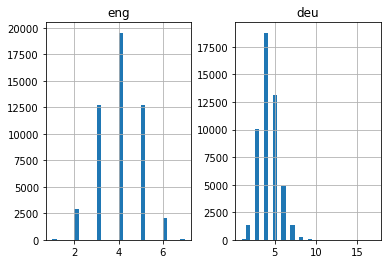

In [ ]:
# 6.1   Let us look at the overall distribution of lengths
#       in the two languages. We can then decide cut-off length

length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8. We will keep both as 8.

### Vectorize now
Transform to integer sequences

Let's vectorize our text data by using Keras's `Tokenizer()` class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

By default, all punctuation is removed, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized. 

0 is a reserved index that won't be assigned to any word.

In [ ]:
"""
Ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
Tokenizer(
          num_words=None,                                     # the maximum number of words to
                                                              #   keep, based on word frequency. 
                                                              #     Only the most common num_words-1 
                                                              #       words will be kept. 
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',     # a string where each element is a char 
                                                              #  that will be filtered from the texts.
                                                              #    The default is all punctuation, plus
                                                              #      tabs and line breaks, minus the ' char
          lower=True,                                         # Convert text to lowercase
          split=' ',                                          # Separator for word splitting
          char_level=False,                                   # If True, every char will be treated as token
          oov_token=None,                                     # if given, it will be added to word_index and 
                                                              #   used to replace out-of-vocabulary words 
                                                              #     during text_to_sequence calls 
          document_count=0
          )

"""

'\nRef: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer\nTokenizer(\n          num_words=None,                                     # the maximum number of words to\n                                                              #   keep, based on word frequency. \n                                                              #     Only the most common num_words-1 \n                                                              #       words will be kept. \n          filters=\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\',     # a string where each element is a char \n                                                              #  that will be filtered from the texts.\n                                                              #    The default is all punctuation, plus\n                                                              #      tabs and line breaks, minus the \' char\n          lower=True,                                         # Convert text to low

In [ ]:
# 7.0  Train tokenizer
#      https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
#      Tokenizer filters punctuation, tabs and line-breaks
#
%%time

tok_eng = Tokenizer()                # Create Tokenizer() object
tok_eng.fit_on_texts(deu_eng[:, 0])  # Just training. No transformation as yet


CPU times: user 629 ms, sys: 1.29 ms, total: 630 ms
Wall time: 636 ms


In [ ]:
# 7.1

%%time

tok_ger = Tokenizer()                # Create Tokenizer() object
tok_ger.fit_on_texts(deu_eng[:, 1])  # Just training. No transformation as yet


CPU times: user 674 ms, sys: 3.31 ms, total: 678 ms
Wall time: 680 ms


In [ ]:
# 7.2 Decide max length of sequences:

eng_length = 8
deu_length = 8      # Could have been 11

In [ ]:
# 7.3  Let us look at some attributes of eng_tokenizer object. 
#      The object is a dictioanry.

print(tok_eng)                      # Output:  <keras_preprocessing.text.Tokenizer at 0x7fe5954012e8>
print(tok_eng.document_count)       # How many documents trained on: 50000
#print(tok_eng.word_index)           # A dictionary 

#list(tok_eng.word_counts.items())[:4] # Count of each word during fit [('hi', 20),('run', 93),('wow', 8),('fire', 49)]
#list(tok_eng.word_index.items())[:10] #  Index/ranking of each word [('tom', 1),('i', 2),('you', 3),...
#list(tok_eng.word_docs.items())[:3]   # Word appeared in how many documents? [('hi', 20),('run', 93),('wow', 8)]

50000


In [ ]:
# 7.4 Get english vocabulary size

eng_vocab_size = len(tok_eng.word_index) + 1
eng_vocab_size

6453

In [ ]:
# 7.5 Similarly Deutch vocab size

deu_vocab_size = len(tok_ger.word_index) + 1
deu_vocab_size

10998

It's time to encode as also pad sequences. We will take German sentences as the input sequences and English sentences as the target sequences. Transformation will be done for both train and test datasets.

#### pad_sequences

This function transforms a list (of length `num_samples`) of sequences (lists of integers) into a 2D Numpy array of shape (`num_samples, num_timesteps`). `num_timesteps` is either the `maxlen` argument if provided, or the length of the longest sequence in the list.

Sequences that are shorter than `num_timesteps` are padded with value until they are `num_timesteps` long.

Sequences longer than `num_timesteps` are truncated so that they fit the desired length.

The position where padding or truncation happens is determined by the arguments `padding` and `truncating`, respectively. Pre-padding or removing values from the beginning of the sequence is the default.

In [ ]:
# pad_sequences syntax:

#tf.keras.preprocessing.sequence.pad_sequences(
#                                              sequences,
#                                              maxlen=None,
#                                              dtype='int32',
#                                              padding='pre',
#                                              truncating='pre',
#                                              value=0.0
#                                              )


##### german data (X)

In [ ]:
# 8.0 X: train german data:
X_train = tok_ger.texts_to_sequences(train[:, 1])

# 8.0.1
X_train = pad_sequences(
                         X_train,
                         maxlen=deu_length ,
                         padding='post'
                        )

In [ ]:
# 8.1 X: test german data:
X_test = tok_ger.texts_to_sequences(test[:, 1])

# 8.1.1
X_test = pad_sequences(
                        X_test,
                        maxlen=deu_length,
                        padding='post'
                      )

##### eng data (y)

In [ ]:
# 8.2 eng data is target, y:
y_train = tok_eng.texts_to_sequences(train[:, 0])

y_train = pad_sequences(
                        y_train,
                        maxlen=eng_length,
                        padding='post'
                        )

In [ ]:
# 8.3 test eng data
y_test = tok_eng.texts_to_sequences(test[:, 0])

y_test = pad_sequences(
                        y_test,
                        maxlen=eng_length,
                        padding='post'
                      )

In [ ]:
# 8.4
print(X_train.shape)      # German sequence: Each sentence is coded into 8 numbers  (40000, 8)
print(y_train.shape)      # English sequence: Each sentence is coded into 8 numbers  (40000, 8)
print(X_train[:4])        # Note that trainY is not OHE
print(y_train[:4])

(40000, 8)
(40000, 8)
[[   8 2926   41  445    0    0    0    0]
 [   1 3339   45   22  150  104    0    0]
 [  42  475  368    5    0    0    0    0]
 [   7   59   30  372   39    0    0    0]]
[[   3  695   46  429    0    0    0    0]
 [   2  521    3   18  100    0    0    0]
 [  84    4   30 1253    6    0    0    0]
 [   7   95   28   57  100    0    0    0]]


## 6.0 Model architecture

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

Please see video below to fully understand the following pictures

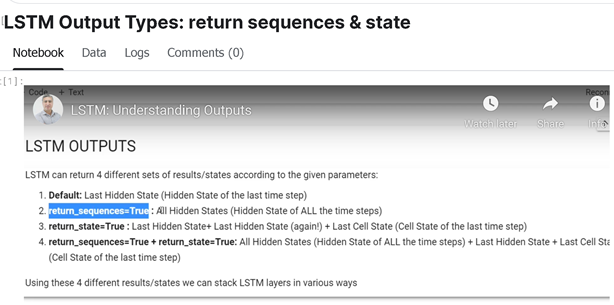

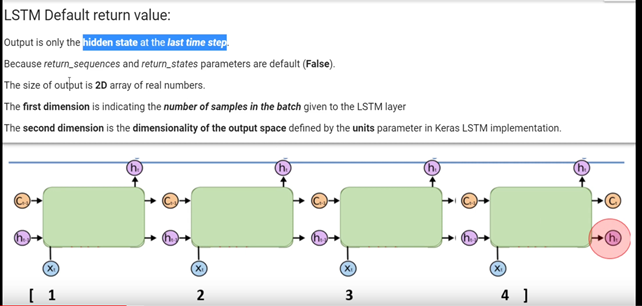

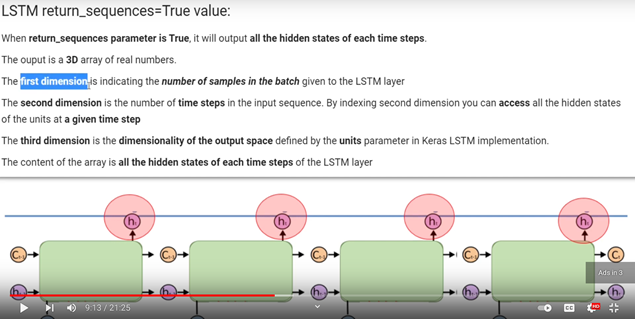

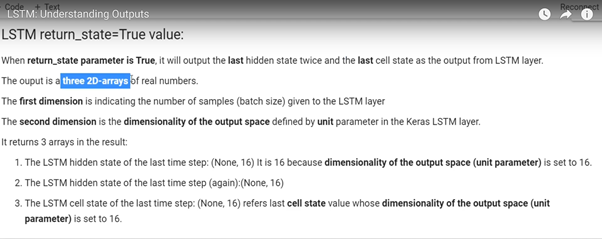

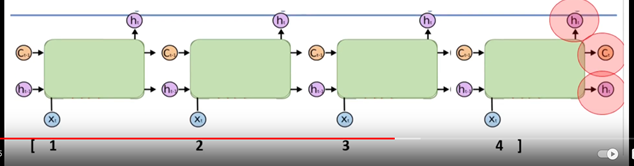

Both resturn_state and return_sequences are True

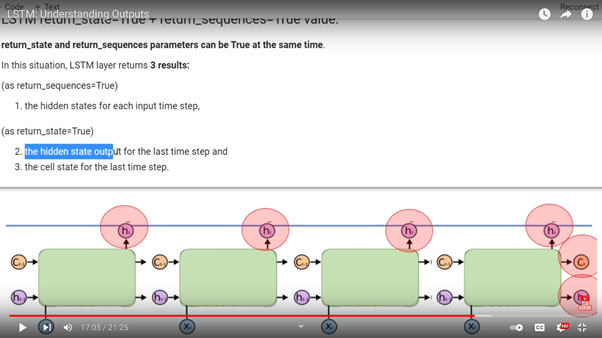

### Model A
We work with this model

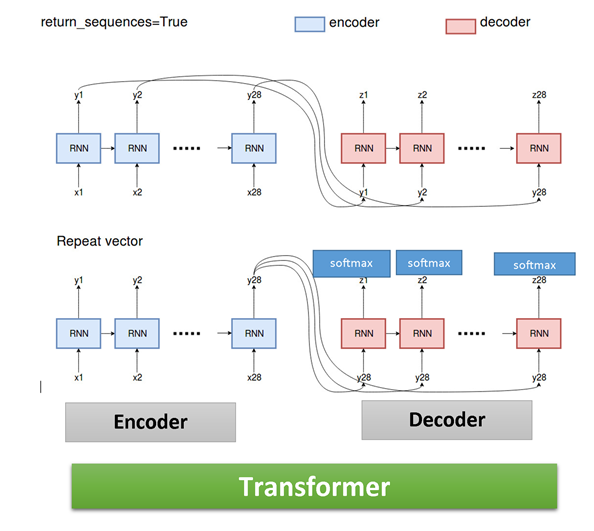

Each RNN is LSTM. The last blue LSTM (x28 input) does not have cell-state output. So the first red RNN (or LSTM) gets only hidden state output of last blue LSTM. Further z1, z2, z3..get fed into softmax layer as above.

In [ ]:
# 9. 
# Ref:
#    1. Return sequence vs Return state
#      https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
#      https://keras.io/layers/recurrent/
#    2. Colah's blog:
#      https://colah.github.io/posts/2015-08-Understanding-LSTMs/
#    3. Repeat vectors
#      https://stackoverflow.com/a/51757012
"""
mask_zero = True
    Whether or not the input value 0 is a special "padding" value
    that should be masked out. This is useful when using recurrent layers
    which may take variable length input. If this is True then all subsequent
    layers in the model need to support masking or an exception will be raised.
    If mask_zero is set to True, as a consequence, index 0 cannot be used in the
    vocabulary (input_dim should equal size of vocabulary + 1).
"""
# See Model architecture here: https://stackoverflow.com/a/51757012

# 9.0.1 Some constants:

#in_vocab = deu_vocab_size,         # in_vocab (german)
#out_vocab = eng_vocab_size,        # out_vocab (english)
#in_timesteps = deu_length,         # in_timesteps (german)
#out_timesteps = eng_length,        # out_timesteps (english)
#word2vec_space_size = 512

'\nmask_zero = True\n    Whether or not the input value 0 is a special "padding" value\n    that should be masked out. This is useful when using recurrent layers\n    which may take variable length input. If this is True then all subsequent\n    layers in the model need to support masking or an exception will be raised.\n    If mask_zero is set to True, as a consequence, index 0 cannot be used in the\n    vocabulary (input_dim should equal size of vocabulary + 1).\n'

In [ ]:
# 9.0.2 Model is here:

def build_model(in_vocab,out_vocab,in_timesteps,out_timesteps,word2vec_space_size):
    model = Sequential()
    # 9.1 Encoder ---------
    model.add(Embedding(in_vocab,             # Decides OneHotEncoder size & no of neurons at input layer
                        word2vec_space_size,  # Decides size of hidden layer
                        input_length=in_timesteps,  # Length of input sequences, when it is constant.
                                                    # This argument is required if you are
                                                    #  going to connect Flatten then Dense layers 
                                                    # upstream (without it, the shape of the dense
                                                    # outputs cannot be computed)
                        mask_zero=True         # Decides if digit zero is a part of vocabulary or not 
                                               # If mask_zero is set to True index 0 cannot be used in
                                               #   the vocabulary (input_dim should equal size 
                                               #    of vocabulary + 1). 
                       )         
             )
    
    model.add(LSTM(word2vec_space_size,        # Decides size of BOTH state-vector as also output-vector
                   return_sequences=False,     # Whether to return the LAST output in the output sequence,
                                               #  or the full sequence ie output of each LSTM. Here only
                                               #    the output of LAST LSTM returned
                                               #      It is 'ht' in Colah's blog
                   return_state = False       
                  )
             )
    
    model.add(RepeatVector(
                           out_timesteps      # How many times earlier input will be repeated
                          )
              )
    
    # The RepeatVector above creates as many inputs
    # as there are out_timesteps. And hence, it forces 
    # the below LSTM to also repeat out_timesteps.
    # See this link for a clear answer:
    #  https://groups.google.com/g/keras-users/c/xxskWHMe_ro/m/dkuI7dckBQAJ

    # 9.2 Decoder ------------
    
    model.add(LSTM(word2vec_space_size,       # Decides size of BOTH state-vector as also output-vector
                   return_sequences=True      # Decides: Return output vector for each LSTM
                  )
             )
    
    # 9.3 Classifier (sort of)
    model.add(Dense(out_vocab,
                    activation='softmax'      # Takes input of EACH LSTM (return sequences = True)
                                              #   and returns one word each. Output is in OHE form
                                              #     and not word2-vetor form
                                              # So there will be as many of these Dense layers, in
                                              #  parallel, as no of return_sequences 
                   )
             )
    
    return model

In [ ]:
# 9.4 Create 1st model

model = build_model(
                     deu_vocab_size,       # in_vocab (german)
                     eng_vocab_size,       # out_vocab (english)
                     deu_length,           # in_timesteps (german)
                     eng_length,           # out_timesteps (english)
                     512
                     )
# 9.4.1
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 512)            5636608   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 6445)           3306285   
                                                                 
Total params: 13,141,293
Trainable params: 13,141,293
Non-trainable params: 0
____________________________________________

Note from above that the decoder has 8 time-steps. And also there are 8 dense layers, one above each LSTM. Number 11009 is the size of vocabulary. So total parameters = `512 * 11009 + 11009 = 5647617 `. That is weights are same for all 8 dense layers.  

In [ ]:
# 9.5 Compile 1st model
rms = optimizers.RMSprop(lr=0.001)
model.compile(
               optimizer=rms,
               loss='sparse_categorical_crossentropy'
              )



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

### Model B


#### Time distributed layer

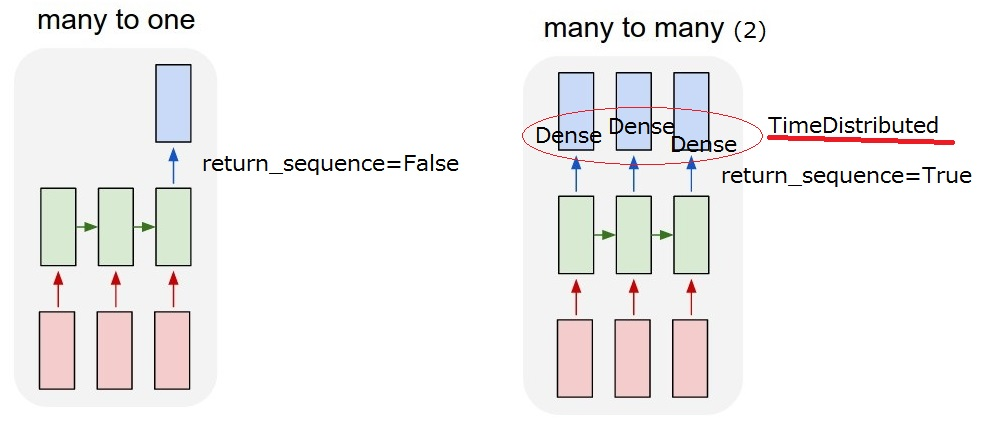

#### Encoder-decoder model

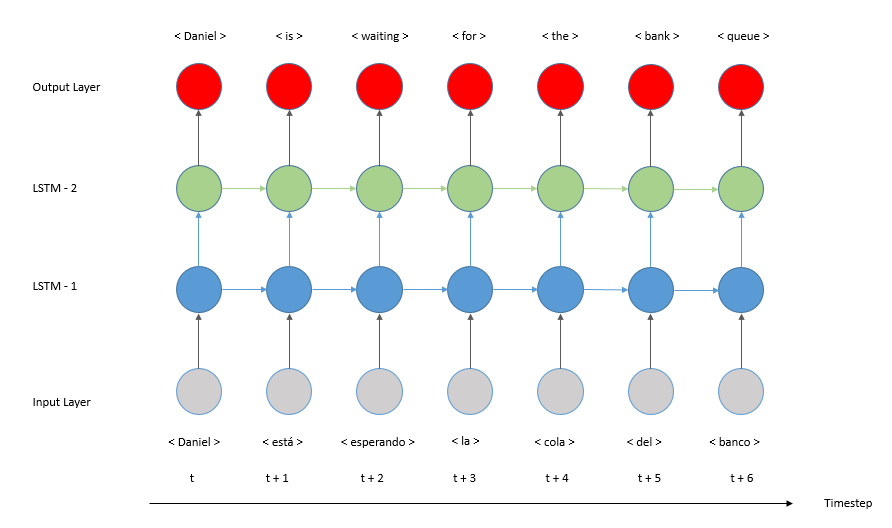

In [ ]:
# 10.0  Model_simple. It is a simpler model
# See Model architecture here: https://stackoverflow.com/a/51757012

def build_model_simple(in_vocab, out_vocab, in_timesteps, out_timesteps, word2vec_space_size):

    model = Sequential()
    model.add(Embedding(in_vocab, word2vec_space_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(word2vec_space_size, return_sequences = True))
    model.add(LSTM(word2vec_space_size, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab,           # Each dense layer outputs one word
                                    activation='softmax'  # One softmax layer with each Dense layer
                                   )
                              )
              )
    #model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# 10.1 Create IInd model
model_simple = build_model_simple(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model_simple.summary()

In [ ]:
# 10.2 Compile IInd simpler model
rms = optimizers.RMSprop(lr=0.001)
model_simple.compile(optimizer=rms,
                     loss='sparse_categorical_crossentropy'
                    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Model C


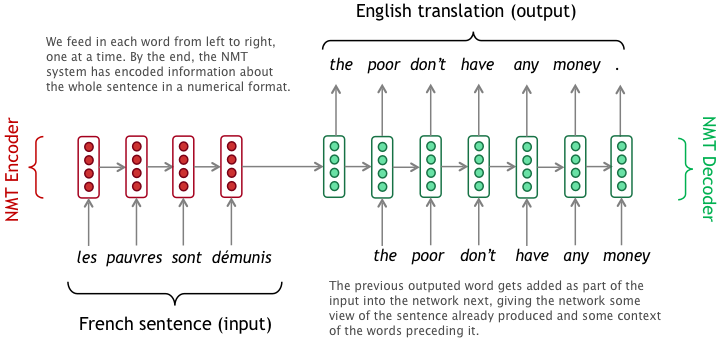

### Model D
See [here](https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571) for one example.  
And see [here](https://www.codespeedy.com/language-translator-rnn-bidirectional-lstms-and-attention-in-python/) for a different architecture but that uses bi-diectional lstm for English-to-hind translation. This example also uses `Attention()`


Bi-directional LSTM

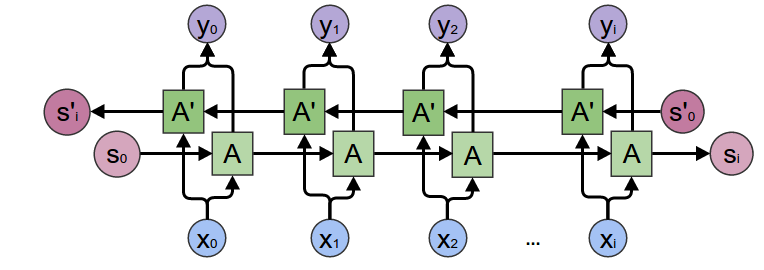

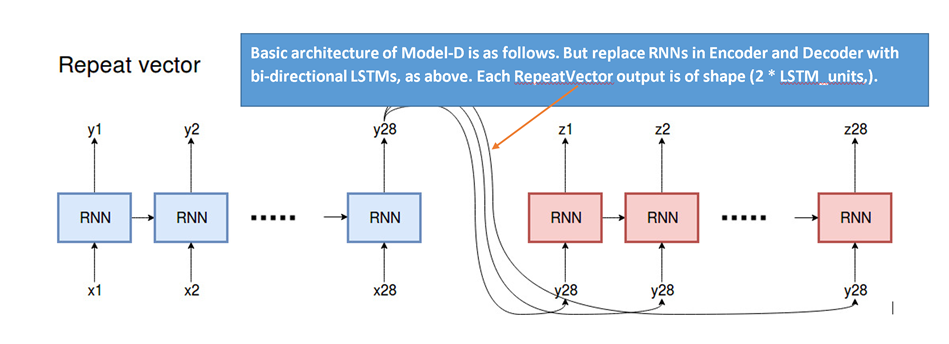

In [ ]:
 # Build the layers  
 
lstm_no_of_units = 64
 
def build_bidirectional_model(in_vocab,out_vocab,in_timesteps,out_timesteps,word2vec_space_size):
  model = Sequential()
  # Embedding
  model.add(Embedding(
                      in_vocab,
                      word2vec_space_size, 
                      input_length=in_timesteps,
                      mask_zero = True
                      )
            )
  
  # Encoder. Unlike in other models
  # we are not using LSTM units same as
  # word2vec_space_size. Just to differentiate
  # between the two parameters. No other reason.

  model.add(Bidirectional(LSTM(lstm_no_of_units), name = "Bidirectional-Encoder"))
  model.add(RepeatVector(out_timesteps))
  # Decoder
  model.add(Bidirectional(LSTM(
                               lstm_no_of_units,
                               return_sequences=True
                               ),
                          name = "Bidirectional-Decoder"
                          )
           )
  model.add(TimeDistributed(Dense(128, activation='relu')))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(
                                     out_vocab,
                                     activation='softmax'
                                     )
                              )
              )
  return model

Note that in *one-directional* LSTM, the output shape would be `(lstm_no_of_units,)`. But in *bi-directional* LSTM, forward and backward LSTM hidden outputs are concatenated and the output shape is `(2 * lstm_no_of_units,)`. See the model summary below.

In [ ]:
# Create the bi-directional model

model_d = build_bidirectional_model(
                                    deu_vocab_size,       # in_vocab (german)
                                    eng_vocab_size,       # out_vocab (english)
                                    deu_length,           # in_timesteps (german)
                                    eng_length,           # out_timesteps (english)
                                    512
                                   )
# 
# Note from model summary that output of LSTM
#  is twice the size of lstm_no_of_units.
#  If lstm_no_of_units is 64, output is NOT
#  64 but 128 which is concatenation of hidden
#  layers in both the direction:

model_d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 8, 512)            5630976   
                                                                 
 Bidirectional-Encoder (Bidi  (None, 128)              295424    
 rectional)                                                      
                                                                 
 repeat_vector_3 (RepeatVect  (None, 8, 128)           0         
 or)                                                             
                                                                 
 Bidirectional-Decoder (Bidi  (None, 8, 128)           98816     
 rectional)                                                      
                                                                 
 time_distributed_4 (TimeDis  (None, 8, 128)           16512     
 tributed)                                            

In [ ]:
# 10.2 Compile IInd simpler model
rms = optimizers.RMSprop(lr=0.001)
model_d.compile(optimizer=rms,
                     loss='sparse_categorical_crossentropy'
                    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Plot model B

In [ ]:
# 10.3 Plot the model_simple architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model_simple, to_file = "model_simple.png");
io.imshow("model_simple.png");

### Plot model A

In [ ]:
# 11.0 Plot the model architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model, to_file = "model.png");
io.imshow("model.png");

### Plot model D

In [ ]:
# Plot the model_simple architecture
# We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model_d, to_file = "model_d.png");
io.imshow("model_d.png");

### About sparse_categorical_crossentropy and categorical_crossentropy
Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function instead of __categorical_crossentropy__. When target is categorical (this is so in our case; targets are 'words' coded as integers). Output layer in our NN model is softmax. So normally we should be converting our trainY to OHE form and calculating error.<br>
But this conversion to OHE would occupy a huge memory because OHE length would depend on vocabulary size (may be many thousands). SO we will have an array of (Many thosands X Many thousands). <br>
'sparse_categorical_crossentropy' allows us to keep our target sequence as integers instead of one hot encoded format.See this [reference](https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/?t=156531526256#rating-57). But if our loss function were categorical_crossentropy then OHE format for trainY is a must.<br>
Incidentally the sparse part doesn't refer to the sparsity of the data but the format of the labels.

We are now all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. Alternative to this is early stopping.

## 7.0 Fitting model A
Also `ModelCheckpoint` saves the best model in VM

In [ ]:
# 12.1
X_train.shape      # (40000, 8)
print("\n===")
X_train[:2,:]        # Look at first two sequences


In [ ]:
# 12.2 We will be reshaping y_train, as follows:
#      y_train is the corresponding german-to-english translation
#      we would expect at each one of the softmax-layer output.


# 12.3 Now reshape and add a third axis
#      Such transformation is required as y_train
#      will serve as desired output of softmax layer
#      For every sequence or sentence of length 8, 
#      softmax outputs are two dimensional (8 X vocab_size).
#      Therefore, for each senetence corresponding trainY 
#      output will also be two dimensional: 8 X 1.

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)  # (40000, 8, 1)
y_train[:2]
y_train.shape

In [ ]:
# 12.4 Remove folder, if it exists, 
#       where we will save our model in VM:

! rm -r -f /content/model
! ls /content

sample_data


In [ ]:
# 13.0 Fit our model:

%%time

epochs = 4

# 13.0.1
filename = '/content/model'
start = time.time()
callbacks_list = [ModelCheckpoint(filename,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min'
                                 ) 
                 ]

# 13.0.2
history =  model.fit( 
                      X_train,       # German phrases
                      y_train,       # Eng phrases: (40000, 8, 1) THIS IS NOT OHE
                                     # EVEN THOUGH OUR MODEL HAS softmax OUTPUT LAYER
                      epochs= epochs,
                      batch_size = 512,
                      validation_split = 0.2,
                      callbacks=callbacks_list,
                      verbose=1
                     )

end = time.time()
print ((end- start)/60)  # 20 minutes

## 8.0 Fitting model B

In [ ]:
# 12.1
X_train.shape      # (40000, 8)
print("\n===")
X_train[:2,:]        # Look at first two sequences


(40000, 8)


===


array([[   8, 2936,   41,  444,    0,    0,    0,    0],
       [   1, 3347,   45,   22,  150,  104,    0,    0]], dtype=int32)

In [ ]:
# 12.2 We will be reshaping y_train, as follows:
#      y_train is the corresponding german-to-english translation
#      we would expect at each one of the softmax-layer output.


# 12.3 Now reshape and add a third axis
#      Such transformation is required as y_train
#      will serve as desired output of softmax layer
#      For every sequence or sentence of length 8, 
#      softmax outputs are two dimensional (8 X vocab_size).
#      Therefore, for each senetence corresponding trainY 
#      output will also be two dimensional: 8 X 1.

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)  # (40000, 8, 1)
y_train[:2]
y_train.shape

In [ ]:
# 12.4 Remove folder, if it exists, 
#       where we will save our model in VM:

! rm -r -f /content/model_simple
! ls /content

sample_data


In [ ]:
# 13.0 Fit our model_simple:

%%time

epochs = 4

# 13.0.1
filename = '/content/model_simple'
start = time.time()
callbacks_list = [ModelCheckpoint(filename,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min'
                                 ) 
                 ]

# 13.0.2
history =  model_simple.fit( 
                            X_train,       # German phrases
                            y_train,       # Eng phrases: (40000, 8, 1) THIS IS NOT OHE
                                     # EVEN THOUGH OUR MODEL HAS softmax OUTPUT LAYER
                            epochs= epochs,
                            batch_size = 512,
                            validation_split = 0.2,
                            callbacks=callbacks_list,
                            verbose=1
                          )

end = time.time()
print ((end- start)/60)  # 20 minutes

## 9.0 Fitting model D

In [ ]:
# 
X_train.shape      # (40000, 8)
print("\n===")
X_train[:2,:]        # Look at first two sequences


(40000, 8)


===


array([[   8, 2926,   41,  445,    0,    0,    0,    0],
       [   1, 3339,   45,   22,  150,  104,    0,    0]], dtype=int32)

In [ ]:
#    We will be reshaping y_train, as follows:
#    y_train is the corresponding german-to-english translation
#    we would expect at each one of the softmax-layer output.


#      Now reshape and add a third axis
#      Such transformation is required as y_train
#      will serve as desired output of softmax layer
#      For every sequence or sentence of length 8, 
#      softmax outputs are two dimensional (8 X vocab_size).
#      Therefore, for each senetence corresponding trainY 
#      output will also be two dimensional: 8 X 1.

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)  # (40000, 8, 1)
y_train[:2]
y_train.shape

In [ ]:
#     Remove folder, if it exists, 
#     where we will save our model in VM:

! rm -r -f /content/model_d
! ls /content

sample_data


In [ ]:
#  Fit our model_d:

%%time

epochs = 4

# 13.0.1
filename = '/content/model_d'
start = time.time()
callbacks_list = [ModelCheckpoint(filename,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min'
                                 ) 
                 ]

# 13.0.2
history =  model_d.fit( 
                            X_train,       # German phrases
                            y_train,       # Eng phrases: (40000, 8, 1) THIS IS NOT OHE
                                     # EVEN THOUGH OUR MODEL HAS softmax OUTPUT LAYER
                            epochs= epochs,
                            batch_size = 512,
                            validation_split = 0.2,
                            callbacks=callbacks_list,
                            verbose=1
                          )

end = time.time()
print ((end- start)/60)  # 20 minutes

## 9.0 Save model A

In [ ]:
# 14.0 Copy the checkpointed model to gdrive
#      Create a folder in gdrive and transfer the model there:

! rm -r -f /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelA
! mkdir -p /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelA
! cp -R /content/model /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelA
! ls /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelA

model


## 10.0 Save model B

In [ ]:
# 14.1 We can now delete our model

#del model    # Delete this model


In [ ]:
# 14.0 Copy the checkpointed model to gdrive
#      Create a folder in gdrive and transfer the model there:

! rm -r -f /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelB
! mkdir -p /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelB
! cp -R /content/model_simple /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelB
! ls /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelB

model_simple


##  Save model D

In [ ]:
#  We can now delete our model

#del model    # Delete this model


In [ ]:
#    Copy the checkpointed model to gdrive
#    Create a folder in gdrive and transfer the model there:

! rm -r -f /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelD
! mkdir -p /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelD
! cp -R /content/model_d /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelD
! ls /gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelD

model_d


## 11.0 Load saved model A
And make predictions

In [ ]:
# 15.0 Create model structure with random data as model weights:

xmodel = build_model(
                     deu_vocab_size,       # in_vocab (german)
                     eng_vocab_size,       # out_vocab (english)
                     deu_length,           # in_timesteps (german)
                     eng_length,           # out_timesteps (english)
                     512
                     )




In [ ]:
# 15.1 Load into this model, saved weights:

xmodel.load_weights('/gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelA/model')

In [ ]:
# 15.2 Make prediction of test data:
#      Refer StackOverflow: https://stackoverflow.com/a/68841446

start = time.time()
# Being softmax and OHE, let us get the integer value
#  of each word by position of max-value in softmax output:

preds = np.argmax(xmodel.predict(X_test), axis=-1)

end = time.time()
(end-start)/60

0.7212507883707683

In [ ]:
preds

array([[ 9,  4,  5, ...,  0,  0,  0],
       [ 9,  4,  5, ...,  0,  0,  0],
       [ 1,  4,  5, ...,  0,  0,  0],
       ...,
       [12, 26,  5, ...,  0,  0,  0],
       [25,  3,  3, ...,  0,  0,  0],
       [ 9,  4,  5, ...,  0,  0,  0]])

## 12.0 Load saved model B
And make predictions

In [ ]:
# 15.0 Create model structure with random data as model weights:

xmodel = build_model_simple(
                     deu_vocab_size,       # in_vocab (german)
                     eng_vocab_size,       # out_vocab (english)
                     deu_length,           # in_timesteps (german)
                     eng_length,           # out_timesteps (english)
                     512
                     )




In [ ]:
# 15.1 Load into this model, saved weights:

xmodel.load_weights('/gdrive/MyDrive/Colab_data_files/germantoenglish/mymodelB/model_simple')

In [ ]:
# 15.2 Make prediction of test data:
#      Refer StackOverflow: https://stackoverflow.com/a/68841446

start = time.time()
preds = np.argmax(xmodel.predict(X_test), axis=-1)
end = time.time()
(end-start)/60

In [ ]:
preds

array([[ 64,   4,  14, ...,   0,   0,   0],
       [ 51,   4,   5, ...,   0,   0,   0],
       [  1,  15, 328, ..., 328, 328, 328],
       ...,
       [  2,  26,   5, ...,   0,   0,   0],
       [ 10,  24,  20, ...,  10,  10,  10],
       [ 25,   4,   3, ...,   0,   0,   0]])

## 13.0 Transform predicted integer-sequences to words

In [ ]:
# 16. Define a function to get word, given integer-index
def get_word(n, tokenizer):
    for word, value in tokenizer.word_index.items():
        if value == n:
            return word
    return None

In [ ]:
# 16.1 Convert sequence predictions to english text
#      Takes time. Be patient....

start = time.time()
preds_text = []
for i in preds:       # For 'i'th row
    temp = []
    for j in range(len(i)):     # For every integer in 'i'th row
        t = get_word(i[j], tok_eng)  # For integer at i[j], get_word()
        if j > 0:     # If j is not 0
            # 16.1 if it is a repeat (sequence) word or no word at all, write ""
            if (t == get_word(i[j-1], tok_eng)) or (t == None):
                temp.append('')
            else:
                # 16.2 Take action normally
                temp.append(t)
             
        else:  # 16.3 if j is 0 
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
    # 16.4 Append the word to list    
    preds_text.append(' '.join(temp))
    
end = time.time()
(end-start)/60           # 3 minutes

1.6421970009803772

In [ ]:
# 16.5 Fill a dataframe with german, actual english and predicted english sentences

pred_df = pd.DataFrame(
                        {
                        'actual_german'  : test[:, 1],      # It is test not testX
                        'actual_english' : test[:, 0],      # Actual english. 
                        'predicted' :      preds_text       # Predicted english
                        }   
                      )

In [ ]:
# 16.6 Results
#      Observe that while translation may not be exact
#      i) words do make some sense,
# and,ii) grammatically most sentences seem correct

pred_df.head(15)

,actual_german,actual_english,predicted
0,Uns ist das Benzin ausgegangen.,We've run out of gas.,please is that
1,Das ist eine vorübergehende Laune.,It's a fad.,that's is a
2,Tom war erschüttert.,Tom was shaken.,tom was three
3,Das stört mich.,This annoys me.,that's won't me
4,Lassen Sie mich das für Sie machen!,Let me do that for you.,don't you me
5,Dafür werden Sie bezahlen!,You will pay for this.,tom won't you
6,Tom schwänzt oft.,Tom often cuts classes.,tom looked his
7,Er ist jung und gesund.,He's young and healthy.,he is
8,Das Leben ist schön.,Life is enjoyable.,that's is
9,"Ich weiß, es klingt albern.",I know it sounds silly.,i know it


In [ ]:
# 16.7 Results"

pred_df.tail(15)

,actual_german,actual_english,predicted
9985,Tom war sich der Risiken bewusst.,Tom knew the risks.,tom was a
9986,Was macht sie?,What does she do?,what did you
9987,Sie liebte ihn immer noch.,She still loved him.,she asked me
9988,Ich möchte vorsichtig sein.,I want to be careful.,i want to
9989,"Ich bin hier, oder?","I'm here, aren't I?",i not the you
9990,Du bist ein Heuchler.,You're a hypocrite.,you not a
9991,Ich gab dir ein Buch.,I gave you a book.,i think you a
9992,Tun wir's!,Let's do it!,are be
9993,Ich hab mir beim Skifahren das Bein gebrochen.,I broke my leg skiing.,i saw to
9994,Ich war siegreich.,I was victorious.,i was a


In [ ]:
# 16.8 Show any 15 samples:

pred_df.sample(15)

,actual_german,actual_english,predicted
3598,Was kochen Sie?,What are you cooking?,what did you
9912,Das ist mein Lieblingslied.,It's my favorite song.,that's is my
6577,Das Essen wird knapp.,Food is running out.,that's has are
7671,Tom nickte ja.,Tom nodded yes.,tom sat his
7520,Sie ist über zwanzig.,She is over twenty.,she is
4267,Ich bin mit einem Kunden zusammen.,I'm with a client.,i not
1710,Können Sie es mir bestellen?,Can you order it for me?,can you do you
8313,Stopp!,Stop!,did
5992,Ich habe nicht geschummelt.,I didn't cheat.,i have the
3674,Das ist sehr gut.,This is very good.,that's is a


In [ ]:
################ I am done ######################

## 14.0 Attention models--Intution
By Andrew Ng

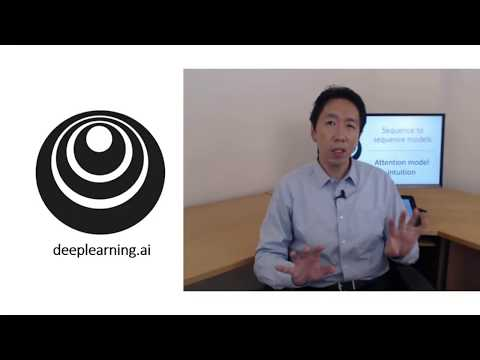

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('SysgYptB198') 

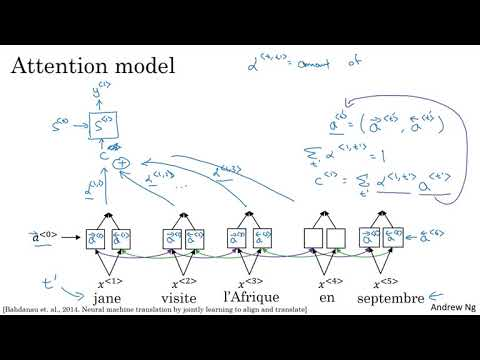

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('FMXUkEbjf9k')

## 15.0 Understaning LSTM parameters
`return_sequences` and `return_state`

Please see on Kaggle a good example and video [here](https://www.kaggle.com/kmkarakaya/lstm-output-types-return-sequences-state)

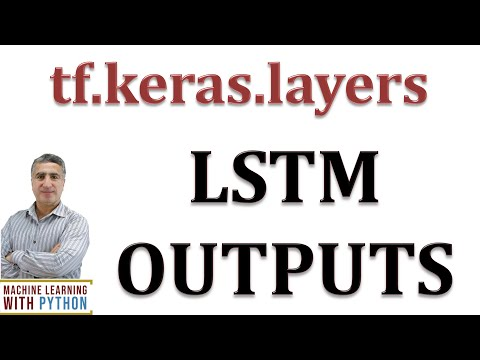

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('B66760rvHA8')

In [ ]:
########################## I am done ###############
################ Below code unchecked ###############

## 13.0 Unchecked code

Let's compare the training loss and the validation loss.

In [ ]:
# 17.2 Plot learning curve: model1
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
# 17.3 Plot learning curve: model2
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
########################## I am done ##############